In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid')

In [2]:
data = pd.read_csv('data/data_train_DF.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

# Replacing clim1 and clim2 by wind
data['wind'] = np.sqrt(data.clim1**2+data.clim2**2)
data.drop(['clim1','clim2'], axis=1, inplace=True)

# Relative humidity
data['RH'] = 100 * np.exp(17.625*(data.clim3-273.15)/(data.clim3-39.11)) / np.exp(17.625*(data.clim4-273.15)/(data.clim4-39.11))

# Dropping NA in new dataframe
data_validation = data[data.BA.isna() | data.CNT.isna()]
data.dropna(inplace=True)
    
data.head(4)

,CNT,BA,lon,lat,area,year,month,lc1,lc2,lc3,...,clim3,clim4,clim5,clim6,clim7,clim8,clim9,clim10,wind,RH
0,0.0,0.0,-95.25,49.25,0.24,1993,3,0.000006,0.015857,0.000023,...,265.457680,268.867126,-0.005898,9.187450e+06,-5231370.5,97849.906250,-0.000340,0.000448,0.277765,76.304978
1,0.0,0.0,-94.75,49.25,0.39,1993,3,0.000005,0.002749,0.000002,...,265.521764,268.412354,-0.001131,6.993830e+06,-4851900.0,97954.703125,-0.000264,0.000462,0.232549,79.479839
2,0.0,0.0,-122.75,48.75,0.48,1993,3,0.002420,0.103964,0.003870,...,276.699820,280.594666,-0.010519,1.052566e+07,-4860741.0,100808.468750,-0.001945,0.004545,1.281072,75.576717
3,3.0,8.0,-122.25,48.75,1.00,1993,3,0.002988,0.237442,0.004040,...,274.943327,278.574371,-0.008420,9.359787e+06,-4653411.5,98474.648438,-0.001256,0.006174,0.963919,76.703795


In [3]:
# List of labels by type
clim_labels = ['altiMean', 'altiSD', 'clim3', 'clim4', 'clim5', 'clim6', 'clim7', 'clim8','clim9', 'clim10', 'wind', 'RH']
land_labels = ['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15','lc16','lc17','lc18']

In [4]:
from sklearn.preprocessing import StandardScaler

# Splitting data to train/test
X_train = data[data.year.isin([1995,2005,2015])].drop('BA', axis=1)
y_train = data[data.year.isin([1995,2005,2015])][['BA']]
X_test  = data[data.year.isin([1997,2007])].drop('BA', axis=1)
y_test  = data[data.year.isin([1997,2007])][['BA']]

# Standardizing climate variables
scaler = StandardScaler()
X_train[clim_labels] = scaler.fit_transform(X_train[clim_labels])
X_test[clim_labels] = scaler.fit_transform(X_test[clim_labels])

In [5]:
# Adding mean CNT per voxel
mean_CNT_voxel = X_train.groupby(['lon','lat'])[['CNT']].mean()
X_train['mean_fire'] = X_train.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)
X_test['mean_fire'] = X_test.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)

In [6]:
X_train.head(4)

,CNT,lon,lat,area,year,month,lc1,lc2,lc3,lc4,...,clim4,clim5,clim6,clim7,clim8,clim9,clim10,wind,RH,mean_fire
49042,0.0,-95.25,49.25,0.24,1995,3,0.000006,0.016773,0.000025,0.001339,...,-2.519617,0.681688,-2.509346,1.130469,0.637303,1.605676,-0.873895,-0.486991,0.900351,0.000000
49043,0.0,-94.75,49.25,0.39,1995,3,0.000005,0.002813,0.000002,0.000241,...,-2.588345,1.493726,-3.020316,1.286596,0.652743,1.692425,-0.901202,-0.194048,1.188057,0.000000
49044,0.0,-122.75,48.75,0.48,1995,3,0.002336,0.103455,0.003785,0.027096,...,-1.261020,-0.049669,-1.776900,0.565023,0.960175,0.010878,1.129725,0.761036,0.922191,0.714286
49045,4.0,-122.25,48.75,1.00,1995,3,0.002988,0.236517,0.004040,0.047353,...,-1.504713,0.414177,-2.118623,0.681306,0.648842,0.752724,2.053845,0.000715,1.111186,2.047619


In [7]:
# Defining Thresholds and Scoring Function
u_CNT = list(range(0,11))+[2*x for x in range(6,16)]+[10*x for x in range(4,11)]
u_BA  = [0,1]+[10*x for x in range(1,11)]+[50*x for x in range(3,7)]+[400,500,1000,1500,2000,5000]+[10000*x for x in range(1,6)]+[100000]

w_CNT = [1-(1+(x+1)**2/1000)**(-1/4) for x in u_CNT] 
w_CNT = [x/w_CNT[-1] for x in w_CNT] 

w_BA  = [1-(1+(x+1)/1000)**(-1/4) for x in u_BA]
w_BA  = [x/w_BA[-1] for x in w_BA]

def cnt_score(y_test, prediction_dist):  
    S_CNT  = 0
    for i in range(len(actual)):
        S_CNT = S_CNT + np.sum([w_CNT[x]*(int(u_CNT[x]>=y_test.iloc[i])-prediction_dist.iloc[i,x])**2 for x in range(len(u_CNT))])
    return S_CNT

def ba_score(y_test, prediction_dist):  
    S_BA  = 0
    for i in range(len(y_test)):
        S_BA = S_BA + np.sum([w_BA[x]*(int(u_BA[x]>=y_test.iloc[i])-prediction_dist.iloc[i,x])**2 for x in range(len(u_BA))])
    return S_BA

In [16]:
# New y_train and y_test that represents intervals of BA :

# method 1 : replace extremes by max u_BA
new_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).fillna(max(u_BA))
new_y_train = pd.DataFrame(new_y_train, columns=['threshold'], index=y_train.index)
new_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).fillna(max(u_BA))
new_y_test = pd.DataFrame(new_y_test, columns=['threshold'], index=y_test.index)

# method 2 : replace extremes by -1
new2_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).add_categories(-1).fillna(-1)
new2_y_train = pd.DataFrame(new2_y_train, columns=['threshold'], index=y_train.index)
new2_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA, right=True, labels=u_BA)).add_categories(-1).fillna(-1)
new2_y_test = pd.DataFrame(new2_y_test, columns=['threshold'], index=y_test.index)

In [9]:
# Appoximation of the prediction distribution - log1p
def dist_log1p(prediction):
    ba_distribution = pd.DataFrame(data=0, index=np.arange(prediction.size), columns=u_BA)
    ba_distribution = ba_distribution.apply(lambda x: stats.norm.cdf(np.log1p(x.name), loc=prediction[x.index], scale=np.std(prediction)), result_type='expand')
    return ba_distribution

# Models

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix, accuracy_score

### Random Forest Regression

In [9]:
%%time

mRF = RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=8, bootstrap=False, random_state=42)
mRF.fit(X_train.drop('CNT', axis=1), np.log1p(y_train.BA))

prediction = mRF.predict(X_test.drop('CNT', axis=1))
ba_distribution = dist_log1p(prediction)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4280

CPU times: user 5min 36s, sys: 536 ms, total: 5min 37s
Wall time: 44.2 s


### Lasso Enhanced Random Forest Regression

In [10]:
%%time

mLasso = Lasso(alpha=0.1)
mLasso.fit(X_train.drop('CNT', axis=1), np.ravel(np.log1p(y_train)))

residuals = np.ravel(np.log1p(y_train))-mLasso.predict(X_train.drop('CNT', axis=1))

mRERF = RandomForestRegressor(max_depth=5, n_estimators=500, n_jobs=10, bootstrap=False, random_state=42)
mRERF.fit(X_train.drop('CNT', axis=1), residuals)

prediction = mLasso.predict(X_test.drop('CNT', axis=1)) + mRERF.predict(X_test.drop('CNT', axis=1))
ba_distribution = dist_log1p(prediction)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4345

CPU times: user 6min 45s, sys: 432 ms, total: 6min 46s
Wall time: 42.4 s


### Random Forest Classifier - with/without CNT

In [18]:
%%time

mRFC0 = RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=8, bootstrap=False, max_features=None, random_state=42)
mRFC0.fit(X_train.drop('CNT', axis=1), new_y_train.threshold)

ba_distribution = pd.DataFrame(mRFC0.predict_proba(X_test.drop('CNT', axis=1)), columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=4079

CPU times: user 14min 58s, sys: 931 ms, total: 14min 58s
Wall time: 1min 56s


In [15]:
%%time

mRFC1 = RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=8, bootstrap=False, max_features=None, random_state=42)
mRFC1.fit(X_train, new_y_train.threshold)

ba_distribution = pd.DataFrame(mRFC1.predict_proba(X_test), columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

## SCORE=3720

CPU times: user 9min 3s, sys: 999 ms, total: 9min 4s
Wall time: 1min 10s


In [16]:
# What the output look like :
ba_distribution

,0,1,10,20,30,40,50,60,70,80,...,1000,1500,2000,5000,10000,20000,30000,40000,50000,100000
0,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
1,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
2,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
3,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
4,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49037,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0
49038,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0
49039,1.0,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
49040,0.0,0.105109,0.555912,0.70073,0.770803,0.815474,0.848175,0.872117,0.886715,0.899562,...,0.984234,0.988905,0.991533,0.997372,0.999416,1.0,1.0,1.0,1.0,1.0


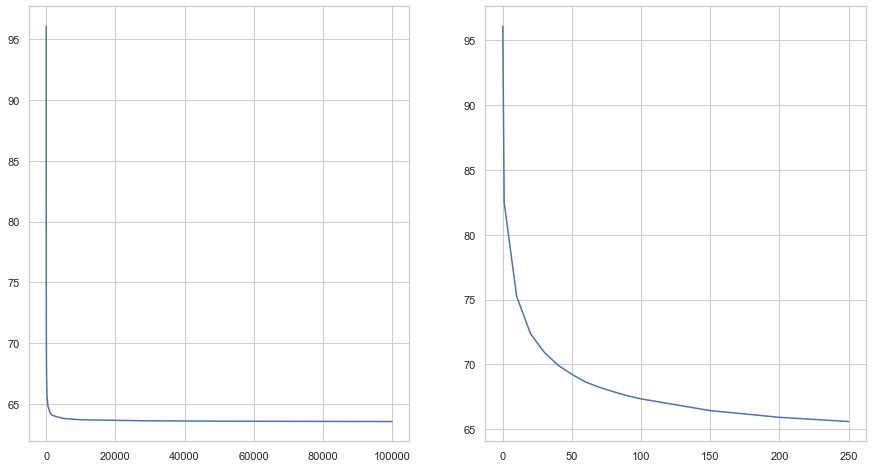

In [19]:
scores = [100*mRFC0.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

### Multi-layer Perceptron classifier

In [43]:
%%time

clf_MLP0 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf_MLP0.fit(X_train.drop('CNT', axis=1), new2_y_train.threshold)

ba_distribution = pd.DataFrame(clf_MLP0.predict_proba(X_test.drop('CNT', axis=1))[:,1:], columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=3856

CPU times: user 25min 9s, sys: 5.19 s, total: 25min 14s
Wall time: 3min 10s


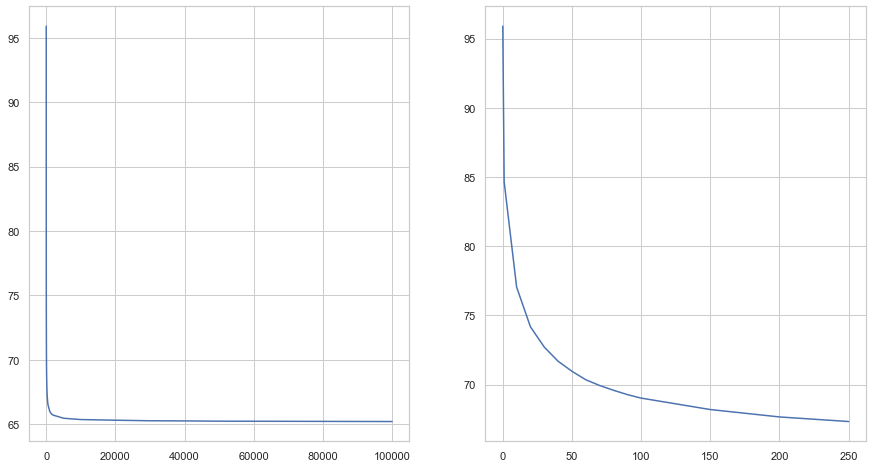

In [44]:
scores = [100*clf_MLP0.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new2_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

In [45]:
%%time

clf_MLP1 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf_MLP1.fit(X_train, new2_y_train.threshold)

ba_distribution = pd.DataFrame(clf_MLP1.predict_proba(X_test)[:,1:], columns=u_BA).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=3465

CPU times: user 14min 40s, sys: 2.84 s, total: 14min 43s
Wall time: 1min 51s


### Try to ignore extremes > 1500

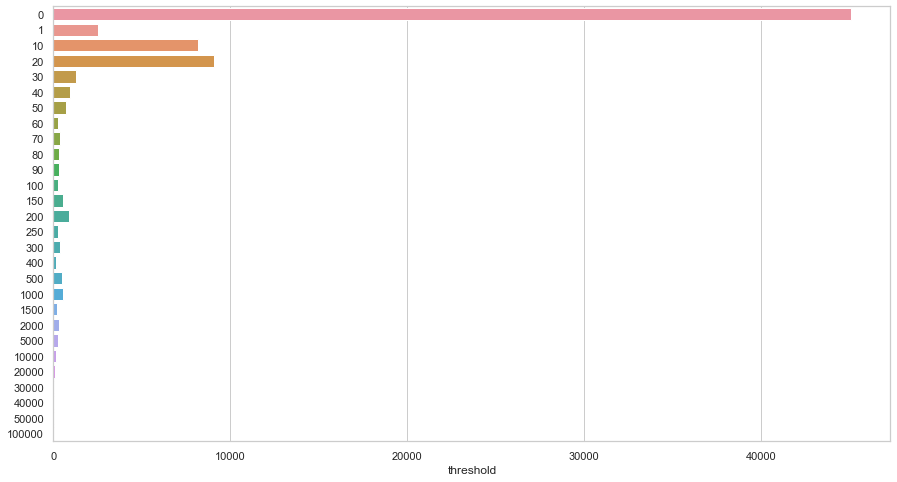

In [29]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.barplot(y=new_y_train.threshold.unique(), x=new_y_train.threshold.value_counts());

CPU times: user 33.3 s, sys: 680 ms, total: 34 s
Wall time: 4.28 s


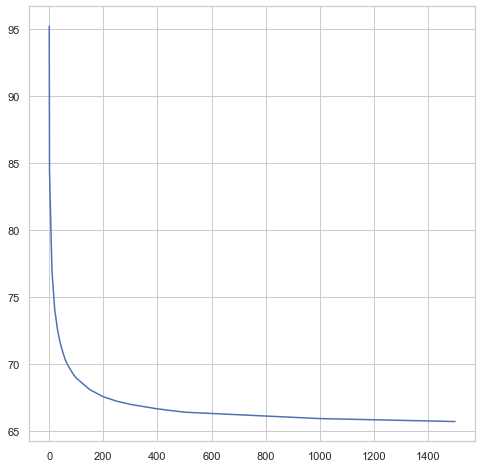

In [110]:
%%time

# put -1 for every BA>1500 as an extreme
new_y_train = pd.Categorical(pd.cut(y_train.BA, bins=[-1]+u_BA[0:20], right=True, labels=u_BA[0:20])).add_categories(-1).fillna(-1)
new_y_train = pd.DataFrame(new_y_train, columns=['threshold'], index=y_train.index)
new_y_test = pd.Categorical(pd.cut(y_test.BA, bins=[-1]+u_BA[0:20], right=True, labels=u_BA[0:20])).add_categories(-1).fillna(-1)
new_y_test = pd.DataFrame(new_y_test, columns=['threshold'], index=y_test.index)

clf = MLPClassifier(random_state=42, max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive')
clf.fit(X_train.drop('CNT', axis=1), new_y_train.threshold)

scores = [100*clf.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), 
                        new_y_test[y_test.BA<=lv].threshold) for lv in u_BA[0:20]]

plt.figure(figsize=(8,8))
plt.plot(u_BA[0:20], scores);

## SMOTE : Classification Balance

In [48]:
from imblearn.over_sampling import SMOTE

In [61]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train[new_y_train.threshold!=-1], new_y_train[new_y_train.threshold!=-1].threshold.cat.remove_categories(-1))

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (73563, 37)
Shape of X after SMOTE: (1262352, 37)

Balance of positive and negative classes (%):


100000    3.571429
50000     3.571429
1         3.571429
10        3.571429
20        3.571429
30        3.571429
40        3.571429
50        3.571429
60        3.571429
70        3.571429
80        3.571429
90        3.571429
100       3.571429
150       3.571429
200       3.571429
250       3.571429
300       3.571429
400       3.571429
500       3.571429
1000      3.571429
1500      3.571429
2000      3.571429
5000      3.571429
10000     3.571429
20000     3.571429
30000     3.571429
40000     3.571429
0         3.571429
Name: threshold, dtype: float64

In [81]:
# select random 80k for now wuth class balance preserved
ind_sm = X_sm.sample(frac=0.2, random_state=42).index
print(len(ind_sm))
y_sm.loc[ind_sm].value_counts(normalize=True) * 100

252470


70        3.644393
200       3.643601
40000     3.611122
150       3.606369
400       3.604389
40        3.598447
10        3.592506
2000      3.588149
20        3.587753
1000      3.580227
60        3.578247
30000     3.576663
300       3.575870
250       3.574682
80        3.573890
50000     3.573890
100000    3.568741
1500      3.551709
10000     3.547748
20000     3.547748
5000      3.543391
30        3.542203
90        3.539430
0         3.539430
50        3.535470
100       3.527152
1         3.527152
500       3.519626
Name: threshold, dtype: float64

In [82]:
%%time

clf = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf.fit(X_sm.loc[ind_sm].drop('CNT', axis=1), y_sm.loc[ind_sm])

ba_distribution = pd.DataFrame(clf.predict_proba(X_test.drop('CNT', axis=1)), columns=y_sm.unique().categories).cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)

# SCORE=

CPU times: user 1h 4min 44s, sys: 36.6 s, total: 1h 5min 21s
Wall time: 8min 13s


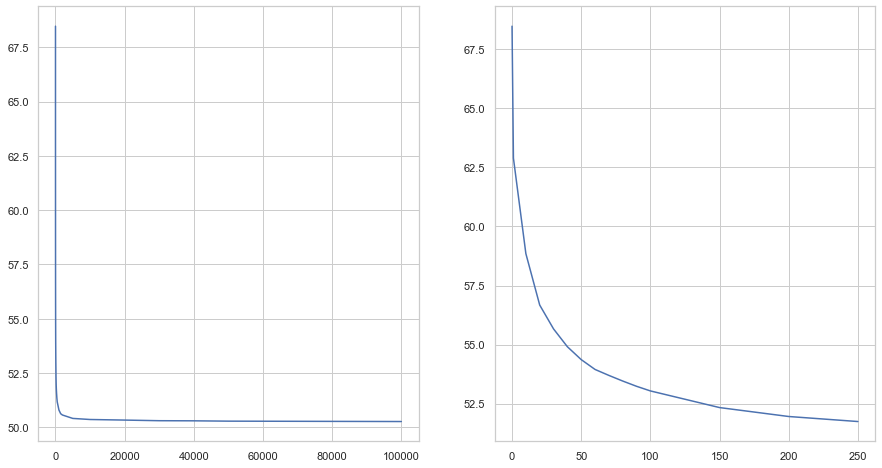

In [83]:
scores = [100*clf.score(X_test[y_test.BA<=lv].drop('CNT', axis=1), new_y_test[y_test.BA<=lv].threshold) for lv in u_BA]

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].plot(u_BA, scores)
ax[1].plot(u_BA[0:15], scores[0:15]);

## Last Model

#### Step 1 : probability BA=0 (True) and BA>0 (False)

In [67]:
%%time

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train==0)

#clf0 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf0 = RandomForestClassifier(max_depth=6, n_estimators=1000, n_jobs=8, bootstrap=False, max_features=None, random_state=42)
clf0.fit(X_sm.drop('CNT', axis=1), y_sm.BA)

CPU times: user 20min 30s, sys: 6.4 s, total: 20min 37s
Wall time: 2min 42s


RandomForestClassifier(bootstrap=False, max_depth=6, max_features=None,
                       n_estimators=1000, n_jobs=8, random_state=42)

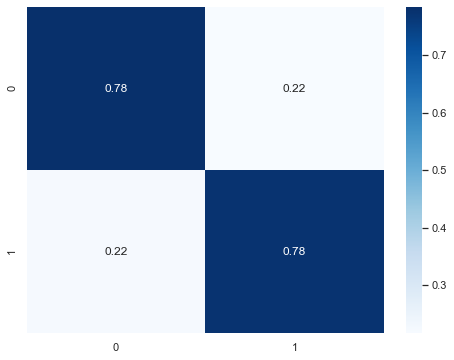

In [68]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test.BA==0, clf0.predict(X_test.drop('CNT', axis=1)), normalize='true'), annot=True, cmap='Blues');

In [75]:
p0 = pd.DataFrame(clf0.predict_proba(X_test.drop('CNT', axis=1))[:,1])
p0.T

,0,1,2,3,4,5,6,7,8,9,...,49032,49033,49034,49035,49036,49037,49038,49039,49040,49041
0,1.0,1.0,0.72179,0.544722,0.544722,0.809344,0.809344,0.809344,0.676783,0.676783,...,0.544722,0.544722,0.619423,0.544722,0.544722,0.14749,0.14749,1.0,0.544722,0.544722


#### Step 2 : classify BA>0

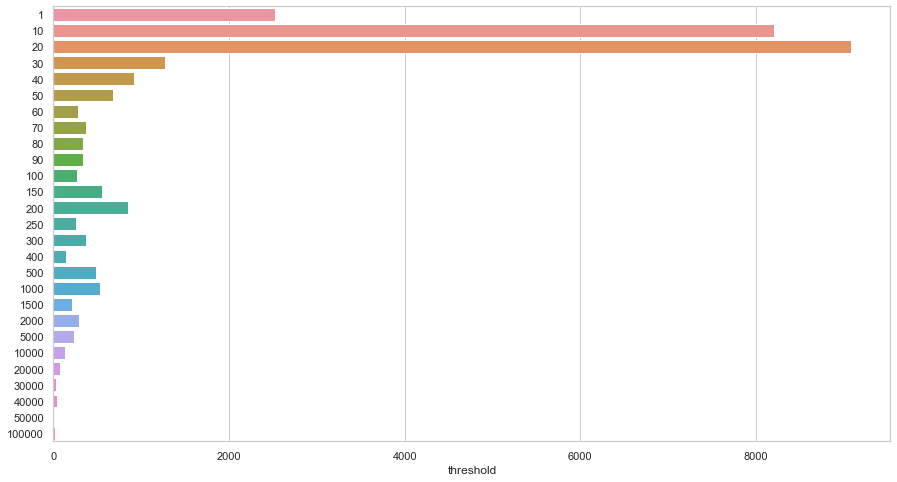

In [82]:
fig, ax = plt.subplots(1, figsize=(15,8))
sns.barplot(y=new_y_train[y_train.BA>0].threshold.unique(), 
            x=new_y_train[y_train.BA>0].threshold.cat.remove_categories(0).value_counts());

In [87]:
%%time

sm1 = SMOTE(random_state=42)
X_sm1, y_sm1 = sm1.fit_resample(X_train[y_train.BA>0], new_y_train[y_train.BA>0])

print(f'''Shape of X before SMOTE: {X_train[y_train.BA>0].shape}
Shape of X after SMOTE: {X_sm1.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm1.value_counts(normalize=True) * 100

Shape of X before SMOTE: (28479, 37)
Shape of X after SMOTE: (245079, 37)

Balance of positive and negative classes (%):
CPU times: user 6.21 s, sys: 598 ms, total: 6.81 s
Wall time: 1.75 s


threshold
100000       3.703704
50000        3.703704
1            3.703704
10           3.703704
20           3.703704
30           3.703704
40           3.703704
50           3.703704
60           3.703704
70           3.703704
80           3.703704
90           3.703704
100          3.703704
150          3.703704
200          3.703704
250          3.703704
300          3.703704
400          3.703704
500          3.703704
1000         3.703704
1500         3.703704
2000         3.703704
5000         3.703704
10000        3.703704
20000        3.703704
30000        3.703704
40000        3.703704
0            0.000000
dtype: float64

In [94]:
%%time

clf1 = MLPClassifier(max_iter=300, activation='relu', alpha=0.0001, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)
clf1.fit(X_sm1.drop('CNT', axis=1), y_sm1.threshold)

CPU times: user 39min 41s, sys: 8.56 s, total: 39min 50s
Wall time: 4min 59s


MLPClassifier(hidden_layer_sizes=100, learning_rate='adaptive', max_iter=300,
              random_state=42)

In [158]:
ba_distribution = pd.DataFrame(clf1.predict_proba(X_test.drop('CNT', axis=1)), columns=u_BA[1:])
ba_distribution = ba_distribution.apply(lambda x: (1-p0[0][x.index])*x)
ba_distribution.insert(0, '0', p0)
ba_distribution = ba_distribution.cumsum(axis=1)
ba_distribution.to_csv('prediction_ba.csv', index=False)
ba_distribution

,0,1,10,20,30,40,50,60,70,80,...,1000,1500,2000,5000,10000,20000,30000,40000,50000,100000
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
2,0.721790,0.891273,0.959016,0.979392,0.983360,0.988485,0.990214,0.991790,0.996736,0.997750,...,0.999987,0.999989,0.999990,0.999992,1.000000,1.0,1.0,1.0,1.0,1.0
3,0.544722,0.880790,0.938248,0.967371,0.974242,0.980076,0.986438,0.992311,0.995856,0.996559,...,0.999998,0.999999,0.999999,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
4,0.544722,0.983365,0.996941,0.999378,0.999547,0.999606,0.999829,0.999945,0.999966,0.999975,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49037,0.147490,0.234020,0.289334,0.315028,0.332055,0.341367,0.372365,0.393636,0.396487,0.403419,...,0.643883,0.693138,0.703081,0.912060,0.950022,1.0,1.0,1.0,1.0,1.0
49038,0.147490,0.163453,0.184859,0.199806,0.209927,0.221815,0.243251,0.260570,0.264436,0.278610,...,0.624068,0.755022,0.784045,0.954481,0.984195,1.0,1.0,1.0,1.0,1.0
49039,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
49040,0.544722,0.571100,0.590971,0.601129,0.607998,0.612840,0.622649,0.629398,0.632285,0.638430,...,0.749806,0.819413,0.832936,0.975550,0.995768,1.0,1.0,1.0,1.0,1.0
